In [1]:
# Packages for training the model and working with the dataset.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json

# Utility/helper packages.
import platform
import time
import pathlib
import os


In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [3]:
CACHE_DIR = './tmp'
pathlib.Path(CACHE_DIR).mkdir(exist_ok=True)

dataset_file_name = 'recipes_raw.zip'
dataset_file_origin = 'https://storage.googleapis.com/recipe-box/recipes_raw.zip'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=CACHE_DIR,
    extract=True,
    archive_format='zip'
)

print(dataset_file_path)

./tmp/datasets/recipes_raw.zip


In [4]:
def load_dataset(silent=True):
    # List of dataset files we want to merge.
    dataset_file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',
    ]
    
    dataset = []

    for dataset_file_name in dataset_file_names:
        dataset_file_path = f'{CACHE_DIR}/datasets/{dataset_file_name}'

        with open(dataset_file_path) as dataset_file:
            json_data_dict = json.load(dataset_file)
            json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list

            # This code block outputs the summary for each dataset.
            if silent == False:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[0], '\n')
                print('Required keys:\n')
                print('  title: ', json_data_list[0]['title'], '\n')
                print('  ingredients: ', json_data_list[0]['ingredients'], '\n')
                print('  instructions: ', json_data_list[0]['instructions'])
                print('\n\n')

    return dataset  

dataset_raw = load_dataset() 

In [5]:
def recipe_validate_required_fields(recipe):
    required_keys = ['title', 'ingredients', 'instructions']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

def recipe_to_string(recipe):
    # This string is presented as a part of recipes so we need to clean it up.
    noize_string = 'ADVERTISEMENT'
    
    title = (recipe['title']).lower()
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f' {ingredient.lower()}\n'
       
    return f'{ingredients_string}'

dataset_raw = load_dataset() 
dataset_validated = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]
print('Stringified dataset size: ', len(dataset_stringified))

MAX_RECIPE_LENGTH = 500
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))

Stringified dataset size:  122938
Dataset size BEFORE filtering:  122938
Dataset size AFTER filtering:  103216


In [6]:
STOP_SIGN = '␣'

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=False,
    filters='\'''!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n®',
    lower=True,
    split=' ',
    oov_token=None,
)

# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])
tokenizer.fit_on_texts(dataset_filtered)
tokenizer.get_config()
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)
#print(tokenizer.word_counts.items())

VOCABULARY_SIZE:  12743


In [7]:
MAX_RECIPE_LENGTH = 500
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))

Dataset size BEFORE filtering:  122938
Dataset size AFTER filtering:  103216


Vectorized dataset size 103216
[4, 209, 160, 61, 226, 246, 2, 7, 20, 2] ...
4 skinless boneless chicken breast halves 2 tablespoons butter 2 10 75 ounce cans condensed cream of chicken soup 1 onion finely diced 2 10 ounce packages refrigerated biscuit dough torn into pieces
Recipe #1 length: 33
Recipe #2 length: 29
Recipe #3 length: 51
Recipe #4 length: 45
Recipe #5 length: 72
Recipe #6 length: 32
Recipe #7 length: 44
Recipe #8 length: 28
Recipe #9 length: 54
Recipe #10 length: 44


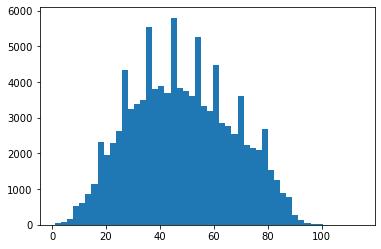

Recipe #0 length: 81
Recipe #1 length: 81
Recipe #2 length: 81
Recipe #3 length: 81
Recipe #4 length: 81
Recipe #5 length: 81
Recipe #6 length: 81
Recipe #7 length: 81
Recipe #8 length: 81
Recipe #9 length: 81
4 skinless boneless chicken breast halves 2 tablespoons butter 2 10 75 ounce cans condensed cream of chicken soup 1 onion finely diced 2 10 ounce packages refrigerated biscuit dough torn into pieces ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣


In [8]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)
print('Vectorized dataset size', len(dataset_vectorized))
print(dataset_vectorized[0][:10], '...')
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    print(recipe_stringified)
recipe_sequence_to_string(dataset_vectorized[0])
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

recipes_lengths = []
for recipe_text in dataset_vectorized:
    recipes_lengths.append(len(recipe_text))

plt.hist(recipes_lengths, bins=50)
plt.show()
MAX_PROC_RECIPE_LENGTH=80

dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure
    # that all recipes will have at least 1 stops sign at the end,
    # since each sequence will be shifted and truncated afterwards
    # (to generate X and Y sequences).
    maxlen=MAX_PROC_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_PROC_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))
    
recipe_sequence_to_string(dataset_vectorized_padded[0])

In [9]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    return input_text, target_text

dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)
dataset_targeted = dataset.map(split_input_target)

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000
dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()
#dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset_train)

<RepeatDataset shapes: ((64, 80), (64, 80)), types: (tf.int32, tf.int32)>


In [10]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.GRU(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.Dense(vocab_size))
    return model

model = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=1024,
  batch_size=BATCH_SIZE
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           3262208   
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 1024)          1049600   
_________________________________________________________________
dense_1 (Dense)              (64, None, 512)           524800    
_________________________________________________________________
dense_2 (Dense)              (64, None, 256)           131328    
_________________________________________________________________
dense_3 (Dense)              (64, None, 128)           32896     
_________________________________________________________________
dense_4 (Dense)              (64, None, 256)           3

In [94]:
# sampling function
Z_DIM=128

def sampling(args):
    mu, log_var = args
    #eps = tf.keras.backend.random_normal(shape=(None, Z_DIM), mean=0., stddev=1.0)
    eps = tf.keras.backend.random_normal(shape=(MAX_PROC_RECIPE_LENGTH, Z_DIM), mean=0., stddev=1.0)
    return mu + tf.keras.backend.exp(log_var) * eps


def build_vae_model(vocab_size, embedding_dim, rnn_units,z_dim, batch_size):
    input_recette = tf.keras.Input(batch_input_shape=(batch_size, None))
    input_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    )(input_recette)
    gru = tf.keras.layers.GRU(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    )(input_layer)
    
    #x_encoded = tf.keras.layers.Flatten()(gru)
    x_encoded = tf.keras.layers.Dense(rnn_units, activation='relu')(gru)
    x_encoded = tf.keras.layers.Dense(rnn_units//2, activation='relu')(x_encoded)
    x_encoded = tf.keras.layers.Dense(rnn_units//4, activation='relu')(x_encoded)

    #mu      = tf.keras.layers.Dense(z_dim)(x_encoded)
    #log_var = tf.keras.layers.Dense(z_dim)(x_encoded)
    #z       = tf.keras.layers.Lambda(sampling, batch_size=batch_size,output_shape=(z_dim,))([mu, log_var])    

    # decoder
    z_decoder0 = tf.keras.layers.Dense(rnn_units//4, activation='relu')(x_encoded)
    z_decoder1 = tf.keras.layers.Dense(rnn_units//2, activation='relu')(z_decoder0)
    z_decoder2 = tf.keras.layers.Dense(vocab_size, activation='relu')(z_decoder1)
    vae = tf.keras.models.Model(input_recette, z_decoder2)
    ae_loss = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=input_recette,
      y_pred=z_decoder2,
      from_logits=True
    )
    #kl_loss = 0.001 * tf.keras.backend.sum(tf.keras.backend.square(mu) + tf.keras.backend.exp(log_var) - log_var - 1, axis = -1)
    vae_loss = ae_loss# + kl_loss
    vae.add_loss(vae_loss)
    return vae
    
model = build_vae_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=32,
  rnn_units=1024,
  z_dim=128,
  batch_size=BATCH_SIZE
)

model.summary()


Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(64, None)]         0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (64, None, 32)       407776      input_22[0][0]                   
__________________________________________________________________________________________________
gru_31 (GRU)                    (64, None, 1024)     3250176     embedding_31[0][0]               
__________________________________________________________________________________________________
dense_184 (Dense)               (64, None, 1024)     1049600     gru_31[0][0]                     
___________________________________________________________________________________________

In [170]:
def build_vae2_model(vocab_size, embedding_dim, rnn_units,z_dim, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.GRU(
        units=rnn_units,#//4
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))
    #model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(rnn_units))
    model.add(tf.keras.layers.Dense(rnn_units//2))#
    model.add(tf.keras.layers.Dense(rnn_units//4))
    ##model.add(tf.keras.layers.Dense(embedding_dim))
    model.add(tf.keras.layers.Dense(rnn_units//4))
    model.add(tf.keras.layers.Dense(rnn_units//2))
    #model.add(tf.keras.layers.Dense(MAX_PROC_RECIPE_LENGTH))
    model.add(tf.keras.layers.Dense(vocab_size))
    #model.add(tf.keras.layers.Dense(vocab_size*MAX_PROC_RECIPE_LENGTH))
    #model.add(tf.keras.layers.Reshape((MAX_PROC_RECIPE_LENGTH,vocab_size)))
    return model
    
model = build_vae2_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256, #small is 64
  rnn_units=1024,#small 
  z_dim=128,
  batch_size=BATCH_SIZE
)

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (64, None, 256)           3262208   
_________________________________________________________________
gru_10 (GRU)                 (64, None, 1024)          3938304   
_________________________________________________________________
dense_35 (Dense)             (64, None, 1024)          1049600   
_________________________________________________________________
dense_36 (Dense)             (64, None, 512)           524800    
_________________________________________________________________
dense_37 (Dense)             (64, None, 256)           131328    
_________________________________________________________________
dense_38 (Dense)             (64, None, 256)           65792     
_________________________________________________________________
dense_39 (Dense)             (64, None, 512)         

In [171]:
def loss(labels, logits):
    #labels_reshape = tf.reshape(labels,[BATCH_SIZE,MAX_PROC_RECIPE_LENGTH])
    #print(labels_reshape.shape,logits.shape)
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    #entropy = tf.keras.losses.mse(
    #  y_true=labels,
    #  y_pred=logits,
    #  #from_logits=True
    #)
    return entropy

In [172]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=loss
    #loss="sparse_categorical_crossentropy"
)
model.summary()
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

# Create a checkpoints directory.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (64, None, 256)           3262208   
_________________________________________________________________
gru_10 (GRU)                 (64, None, 1024)          3938304   
_________________________________________________________________
dense_35 (Dense)             (64, None, 1024)          1049600   
_________________________________________________________________
dense_36 (Dense)             (64, None, 512)           524800    
_________________________________________________________________
dense_37 (Dense)             (64, None, 256)           131328    
_________________________________________________________________
dense_38 (Dense)             (64, None, 256)           65792     
_________________________________________________________________
dense_39 (Dense)             (64, None, 512)         

In [173]:
model_name = 'recipe_generation_rnn_raw_vae.h5'#recipe_generation_rnn_raw.h5'
model.load_weights(model_name)

In [178]:
EPOCHS = 15
INITIAL_EPOCH = 1
STEPS_PER_EPOCH = 1500

print('EPOCHS:          ', EPOCHS)
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)
print(dataset_train)
tf.train.latest_checkpoint(checkpoint_dir)
history = model.fit(
    x=dataset_train,
    #y=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = 'recipe_generation_rnn_raw_vae.h5' #note raw vae is rnn:1024 and embedding dim=256
model.save(model_name, save_format='h5')

EPOCHS:           15
INITIAL_EPOCH:    1
STEPS_PER_EPOCH:  1500
<RepeatDataset shapes: ((64, 80), (64, 80)), types: (tf.int32, tf.int32)>
Epoch 2/15
1500/1500 [==============================] - 80s 54ms/step - loss: 0.8807
Epoch 3/15
1500/1500 [==============================] - 80s 54ms/step - loss: 0.8753
Epoch 4/15
1500/1500 [==============================] - 80s 54ms/step - loss: 0.8720
Epoch 5/15
1500/1500 [==============================] - 81s 54ms/step - loss: 0.8688
Epoch 6/15
1500/1500 [==============================] - 81s 54ms/step - loss: 0.8662
Epoch 7/15
1500/1500 [==============================] - 80s 54ms/step - loss: 0.8632
Epoch 8/15
1500/1500 [==============================] - 80s 54ms/step - loss: 0.8621
Epoch 9/15
1500/1500 [==============================] - 81s 54ms/step - loss: 0.8615
Epoch 10/15
1500/1500 [==============================] - 81s 54ms/step - loss: 0.8571
Epoch 11/15
1500/1500 [==============================] - 80s 54ms/step - loss: 0.8611
Epoch 12/1

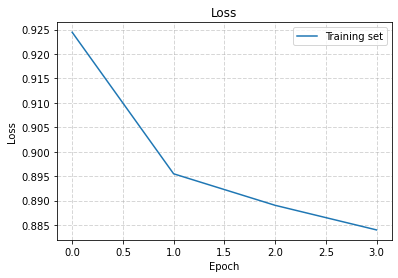

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (1, None, 256)            3262208   
_________________________________________________________________
gru_11 (GRU)                 (1, None, 1024)           3938304   
_________________________________________________________________
dense_41 (Dense)             (1, None, 1024)           1049600   
_________________________________________________________________
dense_42 (Dense)             (1, None, 512)            524800    
_________________________________________________________________
dense_43 (Dense)             (1, None, 256)            131328    
_________________________________________________________________
dense_44 (Dense)             (1, None, 256)            65792     
_________________________________________________________________
dense_45 (Dense)             (1, None, 512)          

In [175]:
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

tf.train.latest_checkpoint(checkpoint_dir)

simplified_batch_size = 1

model_simplified = build_vae2_model(VOCABULARY_SIZE,256, 1024, 128, simplified_batch_size)#64
model_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model_simplified.build(tf.TensorShape([simplified_batch_size, None]))

model_simplified.summary()

In [133]:
def generate_text(model, start_string, num_generate = 100, temperature=1.0):
    #padded_start_string = start_string + ' '
    input_indices = np.array(tokenizer.texts_to_sequences([start_string]))
    #print(input_indices,len(input_indices[0]))
    #for val in range(MAX_PROC_RECIPE_LENGTH-len(input_indices[0])):
    #    input_indices = np.append(input_indices,tokenizer.texts_to_sequences([STOP_SIGN])[0])
    #print(input_indices)
    text_generated = []
    model.reset_states()
    predictions = model(input_indices)
    #print("here",predictions)
    predictions = tf.squeeze(predictions, 0)
    out_arr = np.array([[]])
    for pR in range(num_generate):
        pVal = int(np.argmax(predictions[pR]))
        if pVal != 7962:
            out_arr = np.append(out_arr,int(pVal))
        #print(np.argmax(predictions[pR]))
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
            ).numpy()
    #print(predicted_id.shape)
    #input_indices = tf.expand_dims([predicted_id], 0)
    #next_character = tokenizer.sequences_to_texts(input_indices.numpy())
    out_arr = np.array([out_arr])
    #next_character = tokenizer.sequences_to_texts(out_arr)#predictions)#predicted_id
    next_character = tokenizer.sequences_to_texts(predicted_id)
    text_generated.extend(next_character)
    return text_generated

In [185]:
def generate_text(model, start_string, num_generate = 100, temperature=1.0):
    padded_start_string = STOP_WORD_TITLE + start_string
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))
    print(input_indices,"!!!")
    text_generated = []
    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)
        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()
        input_indices = tf.expand_dims([predicted_id], 0)
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]
        text_generated.append(next_character)
    return (padded_start_string+ ' ' + ' '.join(text_generated))

In [135]:
def generate_combinations(model):
    recipe_length = 80
    #try_letters = ['', '\n', 'A', 'B', 'C', 'O', 'L', 'Mushroom', 'Apple', 'Slow', 'Christmass', 'The', 'Banana', 'Homemade']
    try_letters = ['beef pineapple']# 'Apple', 'Slow', 'Christmass', 'The', 'Banana', 'Homemade']
    try_temperature = [1.0, 0.8, 0.4, 0.2]
    test = np.array([dataset_vectorized_padded[298]])
    #test[0] = test[0,0:79]
    test = np.array([test[0][0:80]])
    try_letters = tokenizer.sequences_to_texts(test)
    
    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')

generate_combinations(model_simplified)

Attempt: "2 cups rolled oats 3 4 cup packed brown sugar 1 2 cup wheat germ 3 4 teaspoon ground cinnamon 1 cup all purpose flour 3 4 cup raisins optional 3 4 teaspoon salt 1 2 cup honey 1 egg beaten 1 2 cup vegetable oil 2 teaspoons vanilla extract ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣" + 1.0
-----------------------------------
['cups', 'cold', 'oats', '3', '4', 'cup', 'granulated', 'cashew', 'milk', '1', '2', 'cup', 'white', 'germ', '1', '2', 'teaspoon', 'ground', 'cinnamon', '1', 'cup', 'all', 'purpose', 'cocoa', '1', '2', 'cup', 'chopped', '1', '1', '4', 'teaspoon', 'baking', '1', '2', 'cup', 'seeds', '2', 'large', 'whites', '1', '4', 'cup', 'brown', 'oil', '1', 'teaspoons', 'vegetable', 's', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣', '␣']



Attempt: "2 cups rolled oats 3 4 cup packed brown sugar 1 2 cup wheat germ 3 4 teaspoon ground cinnamon 1 cup all pu

In [68]:
test = np.array([[ 523., 163.,  99., 450., 742.,  28., 450.]])
tokenizer.sequences_to_texts(test)
#model.predict(dataset_train[0])

['slice cheddar optional banana favorite sliced banana']

In [158]:
def generate_combinations(model):
    recipe_length = 80
    #try_letters = ['', '\n', 'A', 'B', 'C', 'O', 'L', 'Mushroom', 'Apple', 'Slow', 'Christmass', 'The', 'Banana', 'Homemade']
    try_letters = ['guava']# 'Apple', 'Slow', 'Christmass', 'The', 'Banana', 'Homemade']
    try_temperature = [1.0, 0.8, 0.4, 0.2]
    #test = np.array([dataset_vectorized_padded[298]])
    #test[0] = test[0,0:79]
    #test = np.array([test[0][0:80]])
    #try_letters = tokenizer.sequences_to_texts(test)
    
    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')

generate_combinations(model_simplified)

[[1479]] !!!
Attempt: "guava" + 1.0
-----------------------------------
📗 guavapaste 4 cardamom pods 1 dozen large eggs 2 jumbo yolks 1 egg white 1 cup sugar ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣



[[1479]] !!!
Attempt: "guava" + 0.8
-----------------------------------
📗 guavawater or jam 4 tablespoons unsalted butter 1 4 cup granulated sugar 3 4 cup all purpose flour 1 2 cup rolled oats ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣



[[1479]] !!!
Attempt: "guava" + 0.4
-----------------------------------
📗 guavapaste 1 4 cup sugar 1 2 cup water 1 cup sugar 1 cup water ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣



[[1479]] !!!
Attempt: "guava" + 0.2
-----------------------------------
📗 guavapaste 1 4 cup sugar 1 4 cup water 1 4 cup fresh lime j

In [200]:
def generate_combinations(model):
    recipe_length = 80
    #try_letters = ['', '\n', 'A', 'B', 'C', 'O', 'L', 'Mushroom', 'Apple', 'Slow', 'Christmass', 'The', 'Banana', 'Homemade']
    try_letters = ['guava']# 'Apple', 'Slow', 'Christmass', 'The', 'Banana', 'Homemade']
    try_temperature = [1.0, 0.8, 0.4, 0.2]
    #test = np.array([dataset_vectorized_padded[298]])
    #test[0] = test[0,0:79]
    #test = np.array([test[0][0:80]])
    #try_letters = tokenizer.sequences_to_texts(test)
    
    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')

generate_combinations(model_simplified)

[[1479]] !!!
Attempt: "guava" + 1.0
-----------------------------------
📗 guava oil or reserved meat salad mix ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣



[[1479]] !!!
Attempt: "guava" + 0.8
-----------------------------------
📗 guava paste 1 2 cup olive oil 2 tablespoons orange juice 1 tablespoon white sugar ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣



[[1479]] !!!
Attempt: "guava" + 0.4
-----------------------------------
📗 guava paste 2 cups vegetable oil 2 cups all purpose flour 2 teaspoons baking powder 1 2 teaspoon salt 1 egg beaten 1 2 cup milk plus more if needed 2 tablespoons grated parmesan cheese 1 4 cup grated ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣



[[1479]] !!!
Attempt: "guava" + 0.2
-----------------------------------
📗 guava paste 